In [5]:
# standard libraries
import pandas as pd
import numpy as np
import time

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow import keras

# scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# parameter optimization
import optuna

import xgboost as xgb

pd.set_option('display.max_columns', None)

# Set custom styles for text color
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'  # Color of the x-axis tick values
plt.rcParams['ytick.color'] = 'white'  # Color of the y-axis tick values

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [6]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [8]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [10]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [11]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [12]:
target = train.columns.to_list()[-1]
# convert target from bool to int
train[target] = train[target].astype(int)
train_target = train[target]

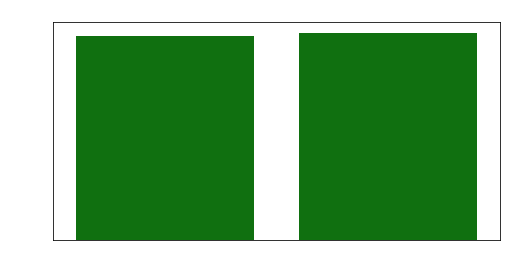

In [13]:
plt.figure(figsize=(8,4))
sns.countplot(data = train, x = target, color='g')
plt.title('Class distribution')
plt.show()

In [14]:
train.drop(target, axis=1, inplace=True)
train_id = train['PassengerId']
test_id = test['PassengerId']

In [15]:
# combine over rows, keeping id for now as group number might be useful
combined = pd.concat([train, test], axis = 0)

### Feature engineering

In [16]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.4+ MB


In [17]:
combined.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [18]:
combined['Group'] = combined['PassengerId'].str[:4]
combined.drop('PassengerId', inplace=True, axis=1)

Categorical columns

In [19]:
# categorical columns
col_cat_NA = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

# fill with Group first
for col in col_cat_NA:
    combined[col] = combined.groupby('Group')[col].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    
# need to do this, so we can use homeplanet to fill values for destination
combined['HomePlanet'].fillna('', inplace=True)
combined['Destination'] = combined.groupby('HomePlanet')['Destination'].transform(
    lambda x: x.fillna(x.mode()[0]))
# reverse what we did earlier
combined['HomePlanet'].replace('', np.nan, inplace=True)

# now fill homeplanet with destination
combined['HomePlanet'] = combined.groupby('Destination')['HomePlanet'].transform(
    lambda x: x.fillna(x.mode()[0]))

combined['CryoSleep'] = combined.groupby('Destination')['CryoSleep'].transform(
    lambda x: x.fillna(x.mode()[0]))
combined['VIP'].fillna(False, inplace=True)
    
# need to break cabin down, this is screwing it up when the entire cabin isn't available
combined[['deck', 'cabin_num', 'side']] = combined['Cabin'].str.split('/', expand=True)

combined.drop('Cabin', inplace=True, axis=1)

col_cat_na = ['deck', 'cabin_num', 'side']

for col in col_cat_na:
    combined[col] = combined.groupby('Destination')[col].transform(
        lambda x: x.fillna(x.mode()[0]))
combined['cabin_num'] = combined['cabin_num'].astype(int)

# drop name
combined.drop('Name', inplace=True, axis=1)

Numerical columns

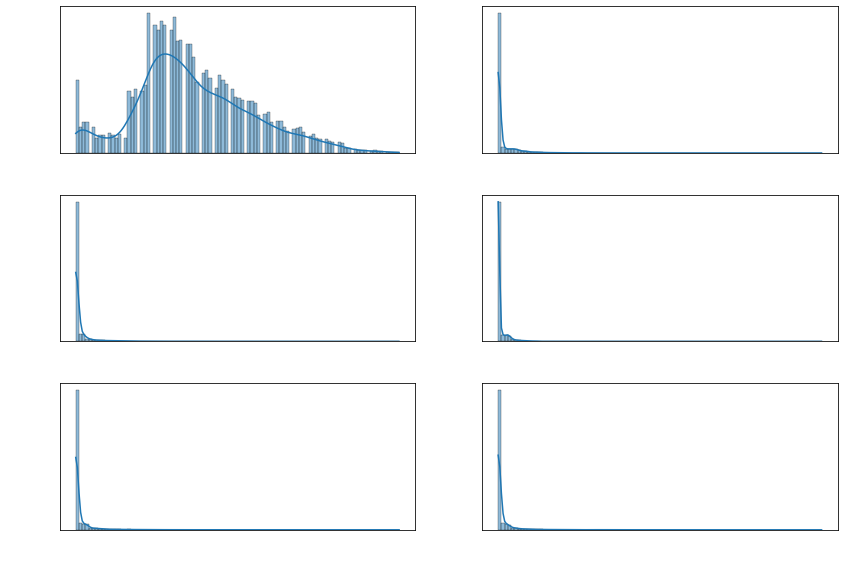

In [20]:
# numerical columns 
col_num = combined.select_dtypes(include=['number']).columns
col_num = col_num.drop(['cabin_num', 'CryoSleep'])

# subplot placehodlers
fig, axes = plt.subplots(3, 2, figsize=(12,8))

# flatten the axes for easier indexing
axes = axes.ravel()

# iterate over number columns, enumerate cause working with index list
for i, col in enumerate(col_num):
    ax = axes[i]
    # checking distribution for data above 0
    t = combined.loc[combined[col]>-1]
    sns.histplot(t[col], ax=ax, kde=True, bins=100)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    
# adjust layout
plt.tight_layout()

plt.show()

In [21]:
display(combined.loc[combined['RoomService']>0].describe())
display(combined.loc[combined['RoomService']>0].median())

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_num
count,4404.000000,4321.000000,4404.000000,4296.000000,4303.000000,4304.000000,4322.000000,4404.000000
mean,0.004087,31.032631,643.134196,484.818203,313.019986,365.609433,337.559695,645.533606
std,0.063808,12.431650,969.486624,1477.621759,657.312688,1118.498526,1187.149866,536.059777
min,0.000000,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,37.000000,0.000000,0.000000,0.000000,0.000000,193.000000
50%,0.000000,28.000000,313.500000,2.000000,19.000000,6.000000,1.000000,471.000000
75%,0.000000,38.000000,857.000000,276.000000,372.000000,245.000000,171.000000,1070.250000
max,1.000000,79.000000,14327.000000,26830.000000,8098.000000,22408.000000,24133.000000,1894.000000


/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_79760/3600371989.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(combined.loc[combined['RoomService']>0].median())


CryoSleep          0.0
Age               28.0
VIP                0.0
RoomService      313.5
FoodCourt          2.0
ShoppingMall      19.0
Spa                6.0
VRDeck             1.0
Group           4639.5
cabin_num        471.0
dtype: float64

In [22]:
# replace 0s with null
# combined[col_num] = combined[col_num].replace(0, np.nan)

# fill with Group first
for i, col in enumerate(col_num):
    combined[col] = combined.groupby('Group')[col].transform(
        lambda x: x.fillna(x.mean()))

In [23]:
# fill with destination now
for i, col in enumerate(col_num):
    combined[col] = combined.groupby('Destination')[col].transform(
        lambda x: x.fillna(x.median()))

In [24]:
# take log due to skewed distribution
for i, col in enumerate(col_num):
    combined[col] = np.log1p(combined[col])

In [25]:
# adding new features
combined['TotalSpent'] = combined[['RoomService', 'FoodCourt', 
                                   'ShoppingMall','Spa', 'VRDeck']].sum(axis=1)

# since the distribution is so skewed to 0s, this might help
# combined['moneySpent'] = (combined['TotalSpent']>0).astype(int)

In [26]:
combined['VIP'].unique()

array([0.0, 1.0], dtype=object)

<Figure size 864x576 with 0 Axes>

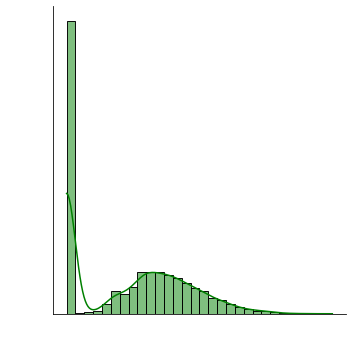

In [27]:
col = 'TotalSpent'
plt.figure(figsize=(12,8))
sns.displot(data=combined, x=col, color='g', kde=True)
plt.show()

In [28]:
col_bool = ['CryoSleep', 'VIP']

# correct dtypes of boolean columns from object to bool then to int
for col in col_bool:
    combined[col] = combined[col].astype(bool).astype(int)

In [29]:
# convert category columns to numerical/binary
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  object 
 1   CryoSleep     12970 non-null  int64  
 2   Destination   12970 non-null  object 
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  int64  
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  Group         12970 non-null  object 
 11  deck          12970 non-null  object 
 12  cabin_num     12970 non-null  int64  
 13  side          12970 non-null  object 
 14  TotalSpent    12970 non-null  float64
dtypes: float64(7), int64(3), object(5)
memory usage: 1.6+ MB


In [30]:
# one hot encoding
combined = pd.get_dummies(combined, columns=['HomePlanet', 'Destination', 'deck', 'side'])

# shouldn't be, but for now, let's...maybe this does make sense after all
combined['Group'] = combined['Group'].astype('int')

In [31]:
# change dtypes to int
combined.iloc[:, -16:] = combined.iloc[:, -16:].astype(int)

In [32]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  12970 non-null  int64  
 1   Age                        12970 non-null  float64
 2   VIP                        12970 non-null  int64  
 3   RoomService                12970 non-null  float64
 4   FoodCourt                  12970 non-null  float64
 5   ShoppingMall               12970 non-null  float64
 6   Spa                        12970 non-null  float64
 7   VRDeck                     12970 non-null  float64
 8   Group                      12970 non-null  int64  
 9   cabin_num                  12970 non-null  int64  
 10  TotalSpent                 12970 non-null  float64
 11  HomePlanet_Earth           12970 non-null  int64  
 12  HomePlanet_Europa          12970 non-null  int64  
 13  HomePlanet_Mars            12970 non-null  int6

In [33]:
# saving a combined copy
combinedCopy = combined.copy(deep=True)

In [34]:
combined = combinedCopy.copy(deep=True)

Min-max Normalization

In [35]:
def min_max_norm(col):
    min_val = col.min()
    max_val = col.max()
    
    return (col-min_val) / (max_val - min_val)

combined = combined.apply(min_max_norm)

### Model design

In [36]:
train = combined.iloc[:train_id.shape[0]]
test = combined.iloc[-test_id.shape[0]:]
train[target] = train_target
print('Train shape', train.shape)
print('Test shape', test.shape)

Train shape (8693, 28)
Test shape (4277, 27)


/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_79760/2658725243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[target] = train_target


In [37]:
# let's split train data into train/test
def train_test_split(data, test_ratio=0.3):
    test_indices = np.random.rand(data.shape[0]) < test_ratio
    return data[~test_indices], data[test_indices]
train_data, test_data = train_test_split(train)
print('{} samples in training, {} samples in testing data'.format(train_data.shape[0], 
                                                            test_data.shape[0]))

6160 samples in training, 2533 samples in testing data


In [38]:
train_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,cabin_num,TotalSpent,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_P,side_S,Transported
0,0.0,0.841820,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.0,0.734563,0.0,0.491170,0.223493,0.323723,0.629907,0.377219,0.000108,0.000000,0.512999,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
2,0.0,0.930514,1.0,0.395423,0.794185,0.000000,0.879710,0.387660,0.000216,0.000000,0.621577,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,0.0,0.646553,0.0,0.597392,0.413743,0.499171,0.632770,0.108866,0.000323,0.000528,0.564936,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
5,0.0,0.868699,0.0,0.000000,0.600043,0.000000,0.566700,0.000000,0.000431,0.000000,0.298540,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8684,1.0,0.725247,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.999353,0.796199,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
8685,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.999461,0.051214,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
8686,0.0,0.797920,0.0,0.072429,0.683790,0.000000,0.392507,0.352315,0.999461,0.051214,0.383287,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8689,1.0,0.671935,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.999784,0.791447,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6160 entries, 0 to 8691
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  6160 non-null   float64
 1   Age                        6160 non-null   float64
 2   VIP                        6160 non-null   float64
 3   RoomService                6160 non-null   float64
 4   FoodCourt                  6160 non-null   float64
 5   ShoppingMall               6160 non-null   float64
 6   Spa                        6160 non-null   float64
 7   VRDeck                     6160 non-null   float64
 8   Group                      6160 non-null   float64
 9   cabin_num                  6160 non-null   float64
 10  TotalSpent                 6160 non-null   float64
 11  HomePlanet_Earth           6160 non-null   float64
 12  HomePlanet_Europa          6160 non-null   float64
 13  HomePlanet_Mars            6160 non-null   float

Model: XGBoost

In [40]:
# single trial
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth = 3)
model.fit(train_data.iloc[:,:-1], train_data[target])
prediction = model.predict(test_data.iloc[:, :-1])
print(accuracy_score(test_data[target], prediction))

In [73]:
# objective function for hyperparameter tuning
def objective(trial):
    # hyperparameter to optimize
    estimators = trial.suggest_int('estimators', 2, 1000)
    depth = trial.suggest_int('depth', 2, 20)
    child_weight = trial.suggest_int('child_weight', 1, 10)
    learn_rate = trial.suggest_float('learn_rate', .001, .5)
    gamma = trial.suggest_float('gamma', 0, 5)
    sub_sample = trial.suggest_float('sub_sample', 0.5, 1)

    # Create and train your machine learning model with the hyperparameters
    model = xgb.XGBClassifier(objective='binary:logistic', 
                             n_estimators = estimators, max_depth = depth,
                             learning_rate = learn_rate,
                             min_child_weight = child_weight,
                             gamma = gamma,
                             subsample = sub_sample)
    
    model.fit(train_data.iloc[:, :-1], train_data[target])
    predictions = model.predict(test_data.iloc[:, :-1])
    
    accuracy = accuracy_score(test_data[target], predictions)

    return accuracy

In [74]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-10-10 22:34:12,720] A new study created in memory with name: no-name-17d70fa4-174d-4c83-bda5-eec8e7026898
[I 2023-10-10 22:34:13,304] Trial 0 finished with value: 0.7935254638768259 and parameters: {'estimators': 385, 'depth': 14, 'child_weight': 2, 'learn_rate': 0.26180429762811036, 'gamma': 0.8530017167370829, 'sub_sample': 0.5461733968014205}. Best is trial 0 with value: 0.7935254638768259.
[I 2023-10-10 22:34:13,413] Trial 1 finished with value: 0.8026056060007896 and parameters: {'estimators': 153, 'depth': 11, 'child_weight': 3, 'learn_rate': 0.3461361080833361, 'gamma': 4.7470871012853095, 'sub_sample': 0.7144061139081483}. Best is trial 1 with value: 0.8026056060007896.
[I 2023-10-10 22:34:13,910] Trial 2 finished with value: 0.8018160284247927 and parameters: {'estimators': 922, 'depth': 9, 'child_weight': 9, 'learn_rate': 0.16061609618660136, 'gamma': 3.7684431983223616, 'sub_sample': 0.556038751949094}. Best is trial 1 with value: 0.8026056060007896.
[I 2023-10-10 22

[I 2023-10-10 22:34:21,453] Trial 28 finished with value: 0.8065534938807738 and parameters: {'estimators': 369, 'depth': 19, 'child_weight': 2, 'learn_rate': 0.05794543527952166, 'gamma': 1.9550823095523502, 'sub_sample': 0.5860025998936196}. Best is trial 15 with value: 0.8085274378207659.
[I 2023-10-10 22:34:22,248] Trial 29 finished with value: 0.805763916304777 and parameters: {'estimators': 375, 'depth': 14, 'child_weight': 2, 'learn_rate': 0.06444033775692887, 'gamma': 0.845729815338776, 'sub_sample': 0.5360276045887093}. Best is trial 15 with value: 0.8085274378207659.
[I 2023-10-10 22:34:23,505] Trial 30 finished with value: 0.7951046190288196 and parameters: {'estimators': 508, 'depth': 16, 'child_weight': 4, 'learn_rate': 0.0018288206701210785, 'gamma': 1.1420311555772886, 'sub_sample': 0.5600074897620623}. Best is trial 15 with value: 0.8085274378207659.
[I 2023-10-10 22:34:23,926] Trial 31 finished with value: 0.8093170153967627 and parameters: {'estimators': 355, 'depth':

[I 2023-10-10 22:34:36,040] Trial 56 finished with value: 0.8049743387287801 and parameters: {'estimators': 287, 'depth': 19, 'child_weight': 3, 'learn_rate': 0.11347266581348983, 'gamma': 2.387573264192808, 'sub_sample': 0.5875952111886362}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:34:36,892] Trial 57 finished with value: 0.8065534938807738 and parameters: {'estimators': 551, 'depth': 16, 'child_weight': 5, 'learn_rate': 0.01693102481326795, 'gamma': 1.9847998511113494, 'sub_sample': 0.6449398920021407}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:34:37,345] Trial 58 finished with value: 0.8006316620607975 and parameters: {'estimators': 470, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.08471336022969164, 'gamma': 1.6431584163988964, 'sub_sample': 0.6176683696126458}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:34:38,186] Trial 59 finished with value: 0.8014212396367943 and parameters: {'estimators': 855, 'depth': 

[I 2023-10-10 22:34:50,406] Trial 85 finished with value: 0.8041847611527833 and parameters: {'estimators': 250, 'depth': 20, 'child_weight': 1, 'learn_rate': 0.03711426954110524, 'gamma': 2.3102208278695175, 'sub_sample': 0.6208003289961287}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:34:50,886] Trial 86 finished with value: 0.8045795499407817 and parameters: {'estimators': 384, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.07451630497723122, 'gamma': 2.1556122644814604, 'sub_sample': 0.5546002787854797}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:34:51,263] Trial 87 finished with value: 0.8037899723647849 and parameters: {'estimators': 169, 'depth': 17, 'child_weight': 3, 'learn_rate': 0.05794705206677098, 'gamma': 2.462473409293928, 'sub_sample': 0.5775390705291465}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:34:51,871] Trial 88 finished with value: 0.803000394788788 and parameters: {'estimators': 232, 'depth': 1

[I 2023-10-10 22:35:05,054] Trial 113 finished with value: 0.7966837741808133 and parameters: {'estimators': 345, 'depth': 11, 'child_weight': 2, 'learn_rate': 0.10314957482789211, 'gamma': 2.3103264122694225, 'sub_sample': 0.5615565406493656}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:35:05,472] Trial 114 finished with value: 0.8069482826687722 and parameters: {'estimators': 295, 'depth': 12, 'child_weight': 1, 'learn_rate': 0.07159240651940216, 'gamma': 2.0043637617227232, 'sub_sample': 0.6255933614233895}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:35:05,867] Trial 115 finished with value: 0.8053691275167785 and parameters: {'estimators': 322, 'depth': 18, 'child_weight': 2, 'learn_rate': 0.06260487389235264, 'gamma': 2.6267632600496595, 'sub_sample': 0.6035157546321304}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:35:06,616] Trial 116 finished with value: 0.8033951835767864 and parameters: {'estimators': 449, 'dep

[I 2023-10-10 22:35:22,434] Trial 141 finished with value: 0.8108961705487564 and parameters: {'estimators': 405, 'depth': 18, 'child_weight': 2, 'learn_rate': 0.02942436365206156, 'gamma': 1.8532378378519936, 'sub_sample': 0.5793087080217588}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:35:23,123] Trial 142 finished with value: 0.8097118041847612 and parameters: {'estimators': 414, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.03219123729835832, 'gamma': 1.8350123566466372, 'sub_sample': 0.5940564645062291}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:35:23,923] Trial 143 finished with value: 0.8085274378207659 and parameters: {'estimators': 414, 'depth': 18, 'child_weight': 2, 'learn_rate': 0.026581841838639878, 'gamma': 1.6790463773140387, 'sub_sample': 0.5798286805956757}. Best is trial 33 with value: 0.8120805369127517.
[I 2023-10-10 22:35:24,532] Trial 144 finished with value: 0.8108961705487564 and parameters: {'estimators': 352, 'de

[I 2023-10-10 22:35:41,232] Trial 169 finished with value: 0.8033951835767864 and parameters: {'estimators': 398, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.1591149842388845, 'gamma': 2.2488015643627883, 'sub_sample': 0.5287583786511465}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:35:42,006] Trial 170 finished with value: 0.8085274378207659 and parameters: {'estimators': 377, 'depth': 10, 'child_weight': 2, 'learn_rate': 0.05437781727473451, 'gamma': 1.9632437123695694, 'sub_sample': 0.582787023086589}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:35:42,494] Trial 171 finished with value: 0.8069482826687722 and parameters: {'estimators': 353, 'depth': 19, 'child_weight': 2, 'learn_rate': 0.04103920591755276, 'gamma': 2.3608588898700056, 'sub_sample': 0.5768970982908713}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:35:42,956] Trial 172 finished with value: 0.8045795499407817 and parameters: {'estimators': 433, 'de

[I 2023-10-10 22:35:56,421] Trial 197 finished with value: 0.803000394788788 and parameters: {'estimators': 400, 'depth': 19, 'child_weight': 5, 'learn_rate': 0.057075773305396836, 'gamma': 1.961806960637115, 'sub_sample': 0.5241089756595123}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:35:57,194] Trial 198 finished with value: 0.8069482826687722 and parameters: {'estimators': 482, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.02437107773770472, 'gamma': 2.1317771998484822, 'sub_sample': 0.5852763169158904}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:35:58,007] Trial 199 finished with value: 0.805763916304777 and parameters: {'estimators': 423, 'depth': 17, 'child_weight': 3, 'learn_rate': 0.012336271048302656, 'gamma': 2.4316592403360424, 'sub_sample': 0.6454682079622465}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:35:58,562] Trial 200 finished with value: 0.8073430714567706 and parameters: {'estimators': 385, 'd

[I 2023-10-10 22:36:10,313] Trial 225 finished with value: 0.8026056060007896 and parameters: {'estimators': 370, 'depth': 17, 'child_weight': 2, 'learn_rate': 0.0890712886979488, 'gamma': 2.2936952439089193, 'sub_sample': 0.8441277392378636}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:10,747] Trial 226 finished with value: 0.8033951835767864 and parameters: {'estimators': 811, 'depth': 17, 'child_weight': 2, 'learn_rate': 0.10184010079755901, 'gamma': 2.141871470167551, 'sub_sample': 0.9112820044200165}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:11,379] Trial 227 finished with value: 0.8065534938807738 and parameters: {'estimators': 875, 'depth': 18, 'child_weight': 2, 'learn_rate': 0.09210434479054534, 'gamma': 2.246805604150431, 'sub_sample': 0.537515125357682}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:12,056] Trial 228 finished with value: 0.8069482826687722 and parameters: {'estimators': 992, 'dept

[I 2023-10-10 22:36:25,696] Trial 253 finished with value: 0.8049743387287801 and parameters: {'estimators': 385, 'depth': 20, 'child_weight': 2, 'learn_rate': 0.1267914120359171, 'gamma': 3.2329136770268643, 'sub_sample': 0.5650133764378941}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:26,730] Trial 254 finished with value: 0.803000394788788 and parameters: {'estimators': 404, 'depth': 17, 'child_weight': 2, 'learn_rate': 0.010229293754683018, 'gamma': 1.904998513143057, 'sub_sample': 0.6009223327787517}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:27,236] Trial 255 finished with value: 0.8081326490327675 and parameters: {'estimators': 374, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.05427444293424681, 'gamma': 2.0408698436467665, 'sub_sample': 0.5531831664860551}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:27,974] Trial 256 finished with value: 0.8081326490327675 and parameters: {'estimators': 786, 'de

[I 2023-10-10 22:36:40,280] Trial 281 finished with value: 0.8018160284247927 and parameters: {'estimators': 363, 'depth': 19, 'child_weight': 7, 'learn_rate': 0.20542723625536086, 'gamma': 2.1684281299421637, 'sub_sample': 0.5426247552856475}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:40,971] Trial 282 finished with value: 0.807737860244769 and parameters: {'estimators': 397, 'depth': 17, 'child_weight': 3, 'learn_rate': 0.02387611032689468, 'gamma': 1.922977767865558, 'sub_sample': 0.5811294762306716}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:41,405] Trial 283 finished with value: 0.803000394788788 and parameters: {'estimators': 449, 'depth': 11, 'child_weight': 2, 'learn_rate': 0.04342375671041467, 'gamma': 2.052801784847987, 'sub_sample': 0.8954526637221256}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:41,840] Trial 284 finished with value: 0.8065534938807738 and parameters: {'estimators': 421, 'dept

[I 2023-10-10 22:36:53,773] Trial 309 finished with value: 0.805763916304777 and parameters: {'estimators': 441, 'depth': 18, 'child_weight': 3, 'learn_rate': 0.08733919465101625, 'gamma': 1.7949733215042876, 'sub_sample': 0.6812992781596358}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:54,329] Trial 310 finished with value: 0.8014212396367943 and parameters: {'estimators': 600, 'depth': 17, 'child_weight': 4, 'learn_rate': 0.09008763984762073, 'gamma': 1.6712637761403748, 'sub_sample': 0.63250782141254}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:54,781] Trial 311 finished with value: 0.7986577181208053 and parameters: {'estimators': 419, 'depth': 20, 'child_weight': 3, 'learn_rate': 0.10021562555279367, 'gamma': 1.4169054812141832, 'sub_sample': 0.7258961689911951}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:36:55,198] Trial 312 finished with value: 0.8093170153967627 and parameters: {'estimators': 582, 'dep

[I 2023-10-10 22:37:09,298] Trial 337 finished with value: 0.807737860244769 and parameters: {'estimators': 908, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.017021397901354648, 'gamma': 1.5313979684548307, 'sub_sample': 0.7422325206965383}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:37:09,865] Trial 338 finished with value: 0.8073430714567706 and parameters: {'estimators': 938, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.16246770635961094, 'gamma': 1.711137924094964, 'sub_sample': 0.818921381733098}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:37:10,527] Trial 339 finished with value: 0.8124753257007501 and parameters: {'estimators': 820, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.039112629843762195, 'gamma': 2.3433739756625163, 'sub_sample': 0.6020456339607265}. Best is trial 149 with value: 0.8136596920647453.
[I 2023-10-10 22:37:11,287] Trial 340 finished with value: 0.8128701144887486 and parameters: {'estimators': 865, 'd

[I 2023-10-10 22:37:33,506] Trial 365 finished with value: 0.8041847611527833 and parameters: {'estimators': 818, 'depth': 20, 'child_weight': 1, 'learn_rate': 0.019273482863809817, 'gamma': 2.8096211070182413, 'sub_sample': 0.6247942080666085}. Best is trial 362 with value: 0.8140544808527438.
[I 2023-10-10 22:37:34,108] Trial 366 finished with value: 0.8093170153967627 and parameters: {'estimators': 796, 'depth': 20, 'child_weight': 1, 'learn_rate': 0.04026353546271714, 'gamma': 2.5913283720191522, 'sub_sample': 0.5911648381038463}. Best is trial 362 with value: 0.8140544808527438.
[I 2023-10-10 22:37:34,879] Trial 367 finished with value: 0.8061587050927753 and parameters: {'estimators': 852, 'depth': 20, 'child_weight': 1, 'learn_rate': 0.025665258907121843, 'gamma': 2.386224454184789, 'sub_sample': 0.6074359539143439}. Best is trial 362 with value: 0.8140544808527438.
[I 2023-10-10 22:37:35,450] Trial 368 finished with value: 0.8053691275167785 and parameters: {'estimators': 749, 

[I 2023-10-10 22:37:50,197] Trial 393 finished with value: 0.8053691275167785 and parameters: {'estimators': 576, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.10184227965532257, 'gamma': 2.078227331421809, 'sub_sample': 0.8173849546170676}. Best is trial 362 with value: 0.8140544808527438.
[I 2023-10-10 22:37:50,870] Trial 394 finished with value: 0.8053691275167785 and parameters: {'estimators': 848, 'depth': 18, 'child_weight': 3, 'learn_rate': 0.03598838419258009, 'gamma': 2.373741546594214, 'sub_sample': 0.5843605131259594}. Best is trial 362 with value: 0.8140544808527438.
[I 2023-10-10 22:37:51,347] Trial 395 finished with value: 0.7998420844848007 and parameters: {'estimators': 811, 'depth': 20, 'child_weight': 2, 'learn_rate': 0.1352179798726551, 'gamma': 2.186533644781449, 'sub_sample': 0.6282048764863946}. Best is trial 362 with value: 0.8140544808527438.
[I 2023-10-10 22:37:51,916] Trial 396 finished with value: 0.8069482826687722 and parameters: {'estimators': 648, 'dept

[I 2023-10-10 22:38:06,917] Trial 421 finished with value: 0.7994472956968022 and parameters: {'estimators': 864, 'depth': 17, 'child_weight': 1, 'learn_rate': 0.04432951714857128, 'gamma': 0.5692262729424225, 'sub_sample': 0.6081073285850028}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:07,364] Trial 422 finished with value: 0.8049743387287801 and parameters: {'estimators': 838, 'depth': 20, 'child_weight': 2, 'learn_rate': 0.11442078240153553, 'gamma': 2.1411076595923317, 'sub_sample': 0.8822843161003129}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:08,819] Trial 423 finished with value: 0.8049743387287801 and parameters: {'estimators': 898, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.01547831574893821, 'gamma': 0.9361743664578377, 'sub_sample': 0.8277010627701972}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:09,221] Trial 424 finished with value: 0.807737860244769 and parameters: {'estimators': 681, 'dept

[I 2023-10-10 22:38:22,779] Trial 449 finished with value: 0.8053691275167785 and parameters: {'estimators': 465, 'depth': 13, 'child_weight': 1, 'learn_rate': 0.05262047740400873, 'gamma': 2.1914593423982485, 'sub_sample': 0.830963107290994}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:23,481] Trial 450 finished with value: 0.8101065929727596 and parameters: {'estimators': 784, 'depth': 10, 'child_weight': 2, 'learn_rate': 0.02759040643923214, 'gamma': 2.018706896975926, 'sub_sample': 0.790116257116183}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:23,941] Trial 451 finished with value: 0.7962889853928149 and parameters: {'estimators': 510, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.14769401534019128, 'gamma': 1.2990606454366471, 'sub_sample': 0.7267491430113119}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:24,386] Trial 452 finished with value: 0.790761942360837 and parameters: {'estimators': 811, 'depth':

[I 2023-10-10 22:38:39,766] Trial 477 finished with value: 0.8069482826687722 and parameters: {'estimators': 870, 'depth': 19, 'child_weight': 2, 'learn_rate': 0.04599925240047747, 'gamma': 2.05404601535507, 'sub_sample': 0.9175727967139663}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:40,404] Trial 478 finished with value: 0.8037899723647849 and parameters: {'estimators': 412, 'depth': 18, 'child_weight': 2, 'learn_rate': 0.0254719993758245, 'gamma': 2.2224580924229587, 'sub_sample': 0.5985425393914234}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:40,922] Trial 479 finished with value: 0.8089222266087643 and parameters: {'estimators': 592, 'depth': 16, 'child_weight': 1, 'learn_rate': 0.05332513845210971, 'gamma': 2.404169869474558, 'sub_sample': 0.7073465368387784}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:41,450] Trial 480 finished with value: 0.8010264508487959 and parameters: {'estimators': 793, 'depth':

[I 2023-10-10 22:38:56,318] Trial 505 finished with value: 0.8006316620607975 and parameters: {'estimators': 522, 'depth': 17, 'child_weight': 1, 'learn_rate': 0.1403744251332877, 'gamma': 1.3903296133164882, 'sub_sample': 0.7264553998155908}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:56,634] Trial 506 finished with value: 0.7911567311488353 and parameters: {'estimators': 419, 'depth': 9, 'child_weight': 2, 'learn_rate': 0.40674350871716736, 'gamma': 2.2818335501665055, 'sub_sample': 0.6785247509344423}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:57,415] Trial 507 finished with value: 0.8073430714567706 and parameters: {'estimators': 804, 'depth': 19, 'child_weight': 2, 'learn_rate': 0.02888461717511292, 'gamma': 2.644831520975515, 'sub_sample': 0.6042083091642918}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:38:57,765] Trial 508 finished with value: 0.8033951835767864 and parameters: {'estimators': 212, 'depth'

[I 2023-10-10 22:39:12,303] Trial 533 finished with value: 0.800236873272799 and parameters: {'estimators': 651, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.37359788043733044, 'gamma': 4.027181269882616, 'sub_sample': 0.8695463580576807}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:13,769] Trial 534 finished with value: 0.8069482826687722 and parameters: {'estimators': 606, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.00956656152652502, 'gamma': 1.8260496742687495, 'sub_sample': 0.6395265701134405}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:14,132] Trial 535 finished with value: 0.7994472956968022 and parameters: {'estimators': 557, 'depth': 17, 'child_weight': 1, 'learn_rate': 0.4155403974714521, 'gamma': 1.714377725676306, 'sub_sample': 0.801738055674974}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:14,586] Trial 536 finished with value: 0.8069482826687722 and parameters: {'estimators': 637, 'depth': 

[I 2023-10-10 22:39:28,026] Trial 561 finished with value: 0.8037899723647849 and parameters: {'estimators': 617, 'depth': 7, 'child_weight': 1, 'learn_rate': 0.05782976956248401, 'gamma': 2.0270478936896486, 'sub_sample': 0.7320701545870849}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:28,495] Trial 562 finished with value: 0.803000394788788 and parameters: {'estimators': 673, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.06861157660819875, 'gamma': 1.7495207732926987, 'sub_sample': 0.9732285720831559}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:29,168] Trial 563 finished with value: 0.8073430714567706 and parameters: {'estimators': 657, 'depth': 9, 'child_weight': 1, 'learn_rate': 0.02049429584197722, 'gamma': 2.1232332075329623, 'sub_sample': 0.7943155817145137}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:29,607] Trial 564 finished with value: 0.7812870114488748 and parameters: {'estimators': 569, 'depth'

[I 2023-10-10 22:39:41,704] Trial 589 finished with value: 0.7931306750888275 and parameters: {'estimators': 659, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.2877556619230658, 'gamma': 2.032567266671828, 'sub_sample': 0.633299796096861}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:42,045] Trial 590 finished with value: 0.8022108172127912 and parameters: {'estimators': 588, 'depth': 18, 'child_weight': 8, 'learn_rate': 0.19515806242411882, 'gamma': 4.768796031859628, 'sub_sample': 0.6726632927891428}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:42,910] Trial 591 finished with value: 0.7970785629688116 and parameters: {'estimators': 620, 'depth': 17, 'child_weight': 2, 'learn_rate': 0.18092545322879303, 'gamma': 0.42854638422774727, 'sub_sample': 0.6236856092268586}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:43,538] Trial 592 finished with value: 0.8093170153967627 and parameters: {'estimators': 668, 'depth'

[I 2023-10-10 22:39:55,881] Trial 617 finished with value: 0.800236873272799 and parameters: {'estimators': 628, 'depth': 3, 'child_weight': 1, 'learn_rate': 0.3020992360842532, 'gamma': 2.1573733177342556, 'sub_sample': 0.5671909203726517}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:56,326] Trial 618 finished with value: 0.8108961705487564 and parameters: {'estimators': 408, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.08569457365080613, 'gamma': 1.9712898354849886, 'sub_sample': 0.5965303562738344}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:56,756] Trial 619 finished with value: 0.7915515199368338 and parameters: {'estimators': 587, 'depth': 17, 'child_weight': 2, 'learn_rate': 0.34034312203345585, 'gamma': 2.6024978446099505, 'sub_sample': 0.5305786858337399}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:39:57,217] Trial 620 finished with value: 0.8089222266087643 and parameters: {'estimators': 464, 'depth'

[I 2023-10-10 22:40:09,182] Trial 645 finished with value: 0.805763916304777 and parameters: {'estimators': 683, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.03311244420947472, 'gamma': 2.2565721675720365, 'sub_sample': 0.8810346599060914}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:09,782] Trial 646 finished with value: 0.7966837741808133 and parameters: {'estimators': 762, 'depth': 18, 'child_weight': 3, 'learn_rate': 0.19296372814676, 'gamma': 1.8791284917733433, 'sub_sample': 0.561660788925861}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:10,179] Trial 647 finished with value: 0.8112909593367549 and parameters: {'estimators': 454, 'depth': 20, 'child_weight': 2, 'learn_rate': 0.16385404493519207, 'gamma': 2.5025733984966583, 'sub_sample': 0.5972381322677849}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:10,564] Trial 648 finished with value: 0.8069482826687722 and parameters: {'estimators': 455, 'depth': 

[I 2023-10-10 22:40:22,792] Trial 673 finished with value: 0.8069482826687722 and parameters: {'estimators': 350, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.02969422336610949, 'gamma': 2.9000025450417066, 'sub_sample': 0.6001915899949871}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:23,147] Trial 674 finished with value: 0.8022108172127912 and parameters: {'estimators': 564, 'depth': 20, 'child_weight': 1, 'learn_rate': 0.2507390881735504, 'gamma': 2.8073347039378045, 'sub_sample': 0.9847016636965719}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:23,722] Trial 675 finished with value: 0.8006316620607975 and parameters: {'estimators': 799, 'depth': 10, 'child_weight': 1, 'learn_rate': 0.17251053595636548, 'gamma': 2.349773534175524, 'sub_sample': 0.5372339065757351}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:24,138] Trial 676 finished with value: 0.8037899723647849 and parameters: {'estimators': 322, 'depth

[I 2023-10-10 22:40:36,995] Trial 701 finished with value: 0.8073430714567706 and parameters: {'estimators': 426, 'depth': 18, 'child_weight': 8, 'learn_rate': 0.3380513970266103, 'gamma': 2.572175530391466, 'sub_sample': 0.838719763897562}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:37,304] Trial 702 finished with value: 0.800236873272799 and parameters: {'estimators': 442, 'depth': 17, 'child_weight': 9, 'learn_rate': 0.26147606129092166, 'gamma': 2.6029610263482836, 'sub_sample': 0.8689756992181943}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:37,619] Trial 703 finished with value: 0.8037899723647849 and parameters: {'estimators': 484, 'depth': 18, 'child_weight': 7, 'learn_rate': 0.3461234039495225, 'gamma': 2.71656661188983, 'sub_sample': 0.8705654955235957}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:37,953] Trial 704 finished with value: 0.7958941966048164 and parameters: {'estimators': 422, 'depth': 17

[I 2023-10-10 22:40:47,971] Trial 730 finished with value: 0.800236873272799 and parameters: {'estimators': 382, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.25295582479102596, 'gamma': 4.916331795345174, 'sub_sample': 0.5688489383317263}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:48,478] Trial 731 finished with value: 0.8085274378207659 and parameters: {'estimators': 844, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.42689388897712843, 'gamma': 2.1657534724964234, 'sub_sample': 0.693417627141939}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:48,905] Trial 732 finished with value: 0.8073430714567706 and parameters: {'estimators': 447, 'depth': 20, 'child_weight': 1, 'learn_rate': 0.17719403576064155, 'gamma': 1.0147126129414312, 'sub_sample': 0.8602089085741624}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:40:49,222] Trial 733 finished with value: 0.805763916304777 and parameters: {'estimators': 397, 'depth':

[I 2023-10-10 22:41:02,853] Trial 758 finished with value: 0.8081326490327675 and parameters: {'estimators': 398, 'depth': 16, 'child_weight': 9, 'learn_rate': 0.26879325918389324, 'gamma': 3.5937724249785887, 'sub_sample': 0.9557195634272312}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:03,210] Trial 759 finished with value: 0.8033951835767864 and parameters: {'estimators': 472, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.1910073020822248, 'gamma': 3.9233541359023114, 'sub_sample': 0.5533230127772569}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:04,890] Trial 760 finished with value: 0.8049743387287801 and parameters: {'estimators': 790, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.017373800096610784, 'gamma': 1.1770529571874044, 'sub_sample': 0.5274524964727351}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:05,291] Trial 761 finished with value: 0.8049743387287801 and parameters: {'estimators': 683, 'dep

[I 2023-10-10 22:41:18,377] Trial 786 finished with value: 0.8033951835767864 and parameters: {'estimators': 637, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.3759416049351051, 'gamma': 4.872401947083112, 'sub_sample': 0.8612922145435461}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:18,833] Trial 787 finished with value: 0.8026056060007896 and parameters: {'estimators': 585, 'depth': 20, 'child_weight': 1, 'learn_rate': 0.1637013189306208, 'gamma': 1.3147713313783906, 'sub_sample': 0.8311160129477297}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:19,337] Trial 788 finished with value: 0.8101065929727596 and parameters: {'estimators': 665, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.08004529441140532, 'gamma': 2.349342628668864, 'sub_sample': 0.748635289995192}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:19,893] Trial 789 finished with value: 0.8045795499407817 and parameters: {'estimators': 686, 'depth': 

[I 2023-10-10 22:41:33,520] Trial 814 finished with value: 0.8061587050927753 and parameters: {'estimators': 598, 'depth': 20, 'child_weight': 1, 'learn_rate': 0.1998272465960396, 'gamma': 3.0257075309673276, 'sub_sample': 0.5303442942574457}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:34,137] Trial 815 finished with value: 0.8006316620607975 and parameters: {'estimators': 737, 'depth': 8, 'child_weight': 1, 'learn_rate': 0.08543496983784554, 'gamma': 2.2020562905256957, 'sub_sample': 0.6468276766330779}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:34,644] Trial 816 finished with value: 0.8010264508487959 and parameters: {'estimators': 891, 'depth': 10, 'child_weight': 1, 'learn_rate': 0.10326563846039408, 'gamma': 2.807385915808049, 'sub_sample': 0.8383677983032809}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:35,180] Trial 817 finished with value: 0.805763916304777 and parameters: {'estimators': 498, 'depth':

[I 2023-10-10 22:41:48,911] Trial 842 finished with value: 0.7919463087248322 and parameters: {'estimators': 651, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.4586121102823813, 'gamma': 2.9539197666648613, 'sub_sample': 0.5672696932518186}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:49,560] Trial 843 finished with value: 0.8053691275167785 and parameters: {'estimators': 384, 'depth': 16, 'child_weight': 1, 'learn_rate': 0.042887828692703904, 'gamma': 1.8634224347085209, 'sub_sample': 0.5200040636172852}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:50,068] Trial 844 finished with value: 0.800236873272799 and parameters: {'estimators': 919, 'depth': 17, 'child_weight': 1, 'learn_rate': 0.3127723936637727, 'gamma': 2.12286581335372, 'sub_sample': 0.8249851489001936}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:41:50,786] Trial 845 finished with value: 0.8101065929727596 and parameters: {'estimators': 818, 'depth':

[I 2023-10-10 22:42:07,014] Trial 870 finished with value: 0.805763916304777 and parameters: {'estimators': 423, 'depth': 20, 'child_weight': 2, 'learn_rate': 0.1961507068039773, 'gamma': 3.3223015340894424, 'sub_sample': 0.9598721266565149}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:07,647] Trial 871 finished with value: 0.8061587050927753 and parameters: {'estimators': 691, 'depth': 20, 'child_weight': 3, 'learn_rate': 0.03777102339730247, 'gamma': 1.9013677020738664, 'sub_sample': 0.7289188409122037}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:08,185] Trial 872 finished with value: 0.8073430714567706 and parameters: {'estimators': 350, 'depth': 20, 'child_weight': 2, 'learn_rate': 0.039244357778686796, 'gamma': 2.0641850229909298, 'sub_sample': 0.5744662035126372}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:08,629] Trial 873 finished with value: 0.8045795499407817 and parameters: {'estimators': 466, 'dept

[I 2023-10-10 22:42:22,489] Trial 898 finished with value: 0.8061587050927753 and parameters: {'estimators': 617, 'depth': 20, 'child_weight': 1, 'learn_rate': 0.032109766309256806, 'gamma': 3.8183570448676556, 'sub_sample': 0.8078506624556998}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:22,809] Trial 899 finished with value: 0.8026056060007896 and parameters: {'estimators': 416, 'depth': 18, 'child_weight': 7, 'learn_rate': 0.3679464127356188, 'gamma': 1.2618457366235067, 'sub_sample': 0.9149196046936541}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:23,483] Trial 900 finished with value: 0.8033951835767864 and parameters: {'estimators': 811, 'depth': 4, 'child_weight': 1, 'learn_rate': 0.1583493690131254, 'gamma': 1.853039828170383, 'sub_sample': 0.5754444729511141}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:24,137] Trial 901 finished with value: 0.8116857481247532 and parameters: {'estimators': 652, 'depth'

[I 2023-10-10 22:42:38,448] Trial 926 finished with value: 0.7998420844848007 and parameters: {'estimators': 854, 'depth': 18, 'child_weight': 1, 'learn_rate': 0.077240687547749, 'gamma': 2.023211986717283, 'sub_sample': 0.54676181714675}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:38,964] Trial 927 finished with value: 0.7891827872088433 and parameters: {'estimators': 545, 'depth': 19, 'child_weight': 2, 'learn_rate': 0.2916421245906415, 'gamma': 1.0125685281993073, 'sub_sample': 0.7337959565463291}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:39,484] Trial 928 finished with value: 0.7872088432688512 and parameters: {'estimators': 774, 'depth': 9, 'child_weight': 1, 'learn_rate': 0.40983351361143794, 'gamma': 2.4517806145405165, 'sub_sample': 0.5728050566526202}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:40,180] Trial 929 finished with value: 0.7883932096328464 and parameters: {'estimators': 386, 'depth': 17

[I 2023-10-10 22:42:53,705] Trial 954 finished with value: 0.7990525069088038 and parameters: {'estimators': 342, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.39589419303527595, 'gamma': 1.967736851115893, 'sub_sample': 0.8481428263696591}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:54,149] Trial 955 finished with value: 0.8061587050927753 and parameters: {'estimators': 599, 'depth': 17, 'child_weight': 6, 'learn_rate': 0.35331768264838614, 'gamma': 2.7648108488383567, 'sub_sample': 0.692337696388241}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:54,874] Trial 956 finished with value: 0.7998420844848007 and parameters: {'estimators': 380, 'depth': 18, 'child_weight': 9, 'learn_rate': 0.05824997319551032, 'gamma': 0.5802931498908914, 'sub_sample': 0.6100178308071181}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:42:55,436] Trial 957 finished with value: 0.780497433872878 and parameters: {'estimators': 424, 'depth'

[I 2023-10-10 22:43:10,218] Trial 982 finished with value: 0.807737860244769 and parameters: {'estimators': 416, 'depth': 19, 'child_weight': 1, 'learn_rate': 0.03069714162865799, 'gamma': 2.3263116375358477, 'sub_sample': 0.7366067267752474}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:43:10,724] Trial 983 finished with value: 0.8041847611527833 and parameters: {'estimators': 681, 'depth': 11, 'child_weight': 1, 'learn_rate': 0.04582599458907216, 'gamma': 3.3316867971615247, 'sub_sample': 0.9030781960158352}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:43:11,327] Trial 984 finished with value: 0.8041847611527833 and parameters: {'estimators': 848, 'depth': 20, 'child_weight': 1, 'learn_rate': 0.02419899036252748, 'gamma': 4.622094230661999, 'sub_sample': 0.5295115601312578}. Best is trial 404 with value: 0.815238847216739.
[I 2023-10-10 22:43:11,794] Trial 985 finished with value: 0.8041847611527833 and parameters: {'estimators': 592, 'depth

CPU times: user 2h 16min 7s, sys: 4min 36s, total: 2h 20min 44s
Wall time: 9min 6s


In [75]:
best_params = study.best_params
best_value = study.best_value
print(best_params)
print(best_value)

{'estimators': 833, 'depth': 16, 'child_weight': 1, 'learn_rate': 0.04717014743346829, 'gamma': 2.3658991688106585, 'sub_sample': 0.6044324681275927}
0.815238847216739


In [80]:
model = xgb.XGBClassifier(objective='binary:logistic', 
                          n_estimators = best_params['estimators'], 
                          max_depth = best_params['depth'],
                          learning_rate = best_params['learn_rate'],
                          min_child_weight = best_params['child_weight'],
                          gamma = best_params['gamma'],
                          subsample = best_params['sub_sample'])
    
model.fit(train.iloc[:, :-1], train[target])
predictions = model.predict(test)

In [82]:
output = pd.DataFrame({'PassengerId': test_id, 'Transported': predictions.squeeze()})
output[target] = (output[target] >= 0.5)
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [79]:
output.to_csv('data/sample_submission.csv', index=False)

Model: Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=10000)
lr.fit(train_data.iloc[:, :-1], train_data[target])

In [ ]:
prediction = lr.predict(test_data.iloc[:, :-1])

In [ ]:
accuracy = accuracy_score(test_data[target], prediction)
print('Accuracy of {}'.format(accuracy))

Model: SVM (takes a while to run this though)

In [ ]:
# param_grid = {
#     'C': [0.1, 1, 10], # regularization parameter
#     'kernel': ['linear', 'rbf'], # kernel type
#     'gamma': [0.1, 1, 10] # kernel coefficient
# }

# svm = SVC()
# grid_search = GridSearchCV(svm, param_grid, cv=5)
# grid_search.fit(train_data.iloc[:, :-1], train_data[target])

# grid_search.best_params_

Model: TFDF

In [ ]:
# convert these to tensorflow datasets
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=target)
test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=target)

In [ ]:
rf = tfdf.keras.RandomForestModel()
rf.fit(train_data)

In [ ]:
rf.summary()

In [ ]:
rf.compile(metrics=['accuracy'])
evaluation = rf.evaluate(test_data, return_dict=True)
display(evaluation)

In [ ]:
# tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

Prediction

In [ ]:
test = tfdf.keras.pd_dataframe_to_tf_dataset(test)
predictions = rf.predict(test)
output = pd.DataFrame({'PassengerId': test_id, 'Transported': predictions.squeeze()})
# convert to boolean
output[target] = (output[target] >= 0.5)

In [ ]:
output.info()

In [ ]:
output.to_csv('data/sample_submission.csv', index=False)

Model : FNN  
Feedforwrad Neural Network

Parameters to optimize 
- layer size
- neuron size
- layer activation? skip this for now
- output activation? skip this for now
- epoch size
- batch size
- learn rate

In [43]:
def fnn_model(layer_size, neuron_size, epoch_size, batch_size, 
              layer_activation, output_activation, 
              feature_size, target_class_count,
              train_data, target, test_data, learn_rate):
    model = keras.Sequential([
        keras.layers.Dense(layer_size, activation=layer_activation, 
                           input_shape=(feature_size,)),
        keras.layers.Dense(neuron_size, activation=layer_activation),
        keras.layers.Dense(target_class_count, activation=output_activation)
    ])

    # optimizer options: SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Ftrl
    optimizer = tf.keras.optimizers.SGD(learning_rate=learn_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    history = model.fit(train_data.drop(columns=target), train_data[target], 
                        epochs = epoch_size, batch_size=batch_size,
                        validation_data=(test_data.drop(columns=target), test_data[target]),
                       verbose=0)
    
    return history, model

Manual Hyperparameter Tuning

In [ ]:
# initialize parameters
layer_list = [32,64]
neuron_list = [4, 16, 64]
epoch_list = [100]
batch_list = [2,4,6]
learn_list = [0.005, 0.01, 0.03]
layer_activation = 'relu'
output_activation = 'sigmoid'
config_list = ['layer_size', 'neuron_size', 'epoch_size',
              'batch_size', 'learn_rate', 'layer_activation',
              'output_activation']

total_iterations = (len(layer_list) * len(neuron_list) * len(epoch_list) * 
                    len(batch_list) * len(learn_list)) 

feature_size = train_data.shape[1]-1 # -1 cause target column
target_class_count = len(train_data[target].unique())-1 # cause binary, 0 doesn't count

history_df = []
i = 0

In [ ]:
%%time

print('# of configurations: ', total_iterations)
for layer_size in layer_list:
    for neuron_size in neuron_list:
        for epoch_size in epoch_list:
            for batch_size in batch_list:
                for learn_rate in learn_list:
                    start_time = time.time()
                    history, model = fnn_model(layer_size, neuron_size, epoch_size, batch_size, 
                                               layer_activation, output_activation, 
                                               feature_size, target_class_count,
                                               train_data, target, test_data, learn_rate)
                    end_time = time.time()
                    
                    df = pd.DataFrame()

                    df['epoch_round'] = [num+1 for num in range(epoch_size)]
                    # add the passed parameters
                    df['layer_size'] = layer_size
                    df['neuron_size'] = neuron_size
                    df['epoch_size'] = epoch_size
                    df['batch_size'] = batch_size
                    df['learn_rate'] = learn_rate
                    df['layer_activation'] = layer_activation
                    df['output_activation'] = output_activation

                    # and now the performance outcomes
                    df['training_loss'] = history.history['loss']
                    df['training_accuracy'] = history.history['accuracy']
                    df['val_loss'] = history.history['val_loss']
                    df['val_accuracy'] = history.history['val_accuracy']
                    
                    # time variables
                    df['timespent'] = end_time - start_time

                    history_df.append(df)
                    
                    i += 1 
                    
                    print(i)
                
history_df = pd.concat(history_df)         

In [ ]:
history_df.describe()

In [ ]:
history_df.sort_values('val_accuracy', ascending=False).head(25)

In [ ]:
config_list = ['layer_size', 'neuron_size', 'epoch_size',
              'batch_size', 'learn_rate', 'layer_activation',
              'output_activation']

In [ ]:
config_results = history_df.drop('epoch_round', axis=1).groupby(config_list)

In [ ]:
config_results = config_results['val_accuracy'].agg(
    min_val = 'min',
    max_val = 'max',
    average = 'mean',
    median = 'median',
    std_dev = 'std',
    variance = 'var'
).reset_index().sort_values('average', ascending=False)

In [ ]:
config_results.head(25)

In [ ]:
t = history_df.loc[(history_df['layer_size'] == 64)
              & (history_df['neuron_size'] == 4)
              & (history_df['batch_size'] == 2)
              & (history_df['learn_rate'] == 0.03)]

plt.figure(figsize=(12,8))
plt.grid(True)

plt.plot(t['epoch_round'], t['training_loss'], marker='o',
        linestyle='-', color='blue', label='training_loss')
plt.plot(t['epoch_round'], t['val_loss'], marker='o',
        linestyle='-', color='green', label='val_loss')

plt.xlabel('epoch_round')
plt.ylabel('loss')
plt.title('Loss visualized')

legend = plt.legend()

# Set the legend text color to white
for text in legend.get_texts():
    text.set_color('black')
    
plt.show()

plt.figure(figsize=(12,8))
plt.grid(True)

plt.plot(t['epoch_round'], t['training_accuracy'], marker='o',
        linestyle='-', color='blue', label='training_accuracy')
plt.plot(t['epoch_round'], t['val_accuracy'], marker='o',
        linestyle='-', color='green', label='val_accuracy')

plt.xlabel('epoch_round')
plt.ylabel('accuracy')
plt.title('Accuracy visualized')

legend = plt.legend()

# Set the legend text color to white
for text in legend.get_texts():
    text.set_color('black')
    
plt.show()

In [44]:
# Manual hypterparameter tuning
# Grid search with expert knowledge...
layer_activation = 'relu'
output_activation = 'sigmoid'

feature_size = train_data.shape[1]-1 # -1 cause target column
target_class_count = len(train_data[target].unique())-1 # cause binary, 0 doesn't count

history, model = fnn_model(64, 4, 20, 2, 
              layer_activation, output_activation, 
              feature_size, target_class_count,
              train_data, target, test_data, 0.04)

In [ ]:
pd.Series(history.history['val_accuracy']).max()

In [ ]:
predictions = model.predict(test)
output = pd.DataFrame({'PassengerId': test_id, 'Transported': predictions.squeeze()})
# convert to boolean
output[target] = (output[target] > 0.5)
output.info()

In [ ]:
output.to_csv('data/sample_submission.csv', index=False)

Bayesian optimizations

In [110]:
# Manual hypterparameter tuning
# Grid search with expert knowledge...
layer_activation = 'relu'
output_activation = 'sigmoid'

feature_size = train_data.shape[1]-1 # -1 cause target column
target_class_count = len(train_data[target].unique())-1 # cause binary, 0 doesn't count

def objective(trial):
    # hyperparameter to optimize
    layer_size = trial.suggest_int('layer_size', 4, 512)
    neuron_size = trial.suggest_int('neuron_size', 2, 256)
    batch_size = trial.suggest_int('batch_size', 2, 512)
    learn_rate = trial.suggest_float('learn_rate', 0.001, 0.05)
    epoch_size = trial.suggest_int('epoch_size', 20, 500)

    # Create and train your machine learning model with the hyperparameters
    history, _ = fnn_model(layer_size, neuron_size, epoch_size, batch_size, 
                  layer_activation, output_activation, 
                  feature_size, target_class_count,
                  train_data, target, test_data, learn_rate)

    # Calculate a performance metric to optimize (e.g., validation accuracy)
    val_accuracy = history.history['val_accuracy'][-1]

    return val_accuracy

In [111]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-10-08 11:25:16,359] A new study created in memory with name: no-name-338cb060-0aec-46c7-af95-9b12e3744669
[I 2023-10-08 11:25:35,609] Trial 0 finished with value: 0.7797067761421204 and parameters: {'layer_size': 487, 'neuron_size': 15, 'batch_size': 203, 'learn_rate': 0.04072054514550381, 'epoch_size': 258}. Best is trial 0 with value: 0.7797067761421204.
[I 2023-10-08 11:26:03,501] Trial 1 finished with value: 0.7943673133850098 and parameters: {'layer_size': 117, 'neuron_size': 92, 'batch_size': 192, 'learn_rate': 0.01555656372226167, 'epoch_size': 442}. Best is trial 1 with value: 0.7943673133850098.
[I 2023-10-08 11:26:36,585] Trial 2 finished with value: 0.7943673133850098 and parameters: {'layer_size': 476, 'neuron_size': 113, 'batch_size': 226, 'learn_rate': 0.014805998657599611, 'epoch_size': 388}. Best is trial 1 with value: 0.7943673133850098.
[I 2023-10-08 11:26:53,956] Trial 3 finished with value: 0.7878086566925049 and parameters: {'layer_size': 228, 'neuron_size'

[I 2023-10-08 11:36:55,938] Trial 32 finished with value: 0.7797067761421204 and parameters: {'layer_size': 147, 'neuron_size': 255, 'batch_size': 95, 'learn_rate': 0.03594141183258075, 'epoch_size': 273}. Best is trial 31 with value: 0.803626537322998.
[I 2023-10-08 11:37:16,412] Trial 33 finished with value: 0.7989969253540039 and parameters: {'layer_size': 205, 'neuron_size': 245, 'batch_size': 211, 'learn_rate': 0.04135630209309766, 'epoch_size': 227}. Best is trial 31 with value: 0.803626537322998.
[I 2023-10-08 11:37:31,367] Trial 34 finished with value: 0.7993826866149902 and parameters: {'layer_size': 80, 'neuron_size': 237, 'batch_size': 126, 'learn_rate': 0.04009950869563374, 'epoch_size': 140}. Best is trial 31 with value: 0.803626537322998.
[I 2023-10-08 11:38:03,328] Trial 35 finished with value: 0.7986111044883728 and parameters: {'layer_size': 236, 'neuron_size': 208, 'batch_size': 192, 'learn_rate': 0.04188507756343654, 'epoch_size': 341}. Best is trial 31 with value: 0

[I 2023-10-08 11:58:35,468] Trial 65 finished with value: 0.8051697611808777 and parameters: {'layer_size': 193, 'neuron_size': 17, 'batch_size': 139, 'learn_rate': 0.04132535436457871, 'epoch_size': 254}. Best is trial 53 with value: 0.8051697611808777.
[I 2023-10-08 11:58:59,328] Trial 66 finished with value: 0.8024691343307495 and parameters: {'layer_size': 190, 'neuron_size': 13, 'batch_size': 109, 'learn_rate': 0.04149706536163626, 'epoch_size': 252}. Best is trial 53 with value: 0.8051697611808777.
[I 2023-10-08 11:59:20,142] Trial 67 finished with value: 0.7974537014961243 and parameters: {'layer_size': 182, 'neuron_size': 16, 'batch_size': 91, 'learn_rate': 0.03881361003094473, 'epoch_size': 233}. Best is trial 53 with value: 0.8051697611808777.
[I 2023-10-08 11:59:42,882] Trial 68 finished with value: 0.8024691343307495 and parameters: {'layer_size': 321, 'neuron_size': 13, 'batch_size': 104, 'learn_rate': 0.036429645963215906, 'epoch_size': 254}. Best is trial 53 with value: 

[I 2023-10-08 12:10:44,664] Trial 98 finished with value: 0.8024691343307495 and parameters: {'layer_size': 145, 'neuron_size': 180, 'batch_size': 139, 'learn_rate': 0.04554021235102636, 'epoch_size': 307}. Best is trial 88 with value: 0.8067129850387573.
[I 2023-10-08 12:11:10,666] Trial 99 finished with value: 0.8032407164573669 and parameters: {'layer_size': 291, 'neuron_size': 222, 'batch_size': 251, 'learn_rate': 0.0478160622165866, 'epoch_size': 206}. Best is trial 88 with value: 0.8067129850387573.


CPU times: user 1h 5min 22s, sys: 19min 59s, total: 1h 25min 21s
Wall time: 45min 54s


In [112]:
best_params = study.best_params
best_value = study.best_value

In [113]:
best_params

{'layer_size': 110,
 'neuron_size': 198,
 'batch_size': 204,
 'learn_rate': 0.04645155314066818,
 'epoch_size': 320}

In [114]:
best_value

0.8067129850387573

In [115]:
# Manual hypterparameter tuning
# Grid search with expert knowledge...
layer_activation = 'relu'
output_activation = 'sigmoid'

feature_size = train_data.shape[1]-1 # -1 cause target column
target_class_count = len(train_data[target].unique())-1 # cause binary, 0 doesn't count

history, model = fnn_model(best_params['layer_size'], best_params['neuron_size'], 
                           best_params['epoch_size'], best_params['batch_size'], 
              layer_activation, output_activation, 
              feature_size, target_class_count,
              train_data, target, test_data, best_params['learn_rate'])

In [116]:
pd.Series(history.history['val_accuracy']).max()

0.8059413433074951

In [117]:
predictions = model.predict(test)
output = pd.DataFrame({'PassengerId': test_id, 'Transported': predictions.squeeze()})
# convert to boolean
output[target] = (output[target] >= 0.5)
output.info()

134/134 [==============================] - 0s 619us/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [118]:
output.to_csv('data/sample_submission.csv', index=False)